In [1]:
ctrl_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
#adata_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
#adata_B = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_B_data.h5ad')
#adata_C = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_C_data.h5ad')

NameError: name 'anndata' is not defined

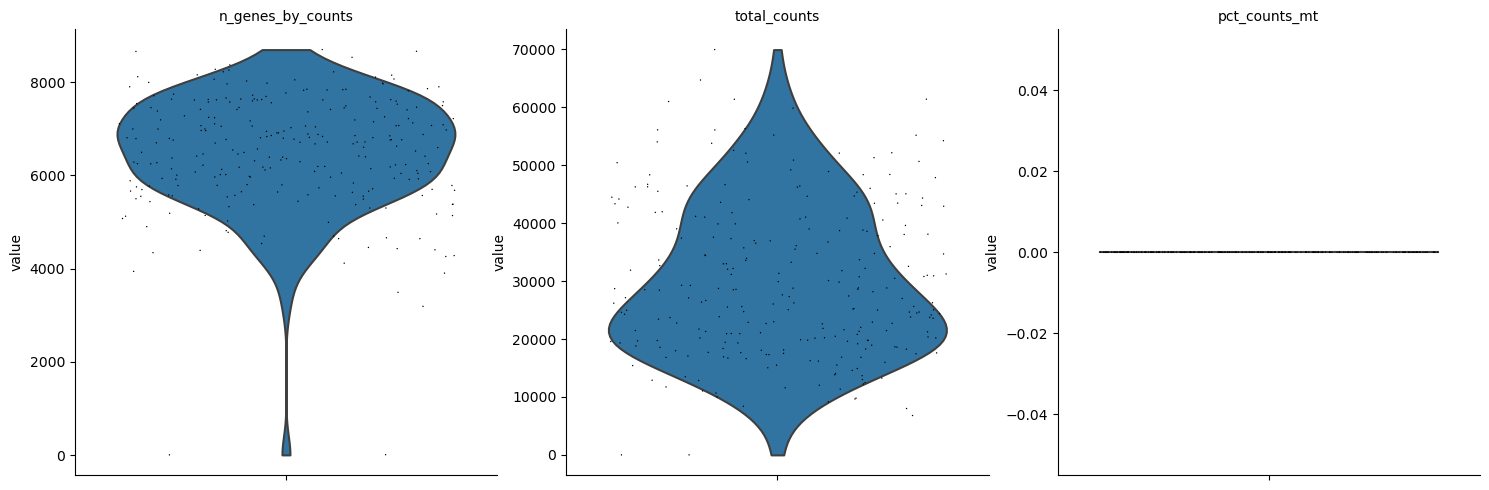

In [1]:
from Algorithm.graph import *
from Algorithm.distribution import *
from IO.read_10X import *
from utils import *


h5_path = 'E://human/GSM4838131_Visium_Sample_A_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838131_Visium_Sample_A_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838133_Visium_Sample_C_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838133_Visium_Sample_C_tissue_positions_list.csv'

h5_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

adata = read_10X_h5ad('F://Rep11_MOB_ST.h5ad', amplification=1000, bin_size=20)
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, inplace=True)

#sc.pp.filter_genes(adata, min_cells=2)
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.var_names_make_unique()

#adata = adata[adata.obs["pct_counts_mt"] < 8]
sc.pl.violin(adata,
             ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pp.filter_genes(adata, min_cells=50)


In [2]:
paper = ['Rab3b', 'Necab2', 'Tspan7', 'Cdr1', 'Slc17a7', '4933405L10Rik', 'Taf7l', 'Gna14', 'Olfr635', 'Pmepa1', 'Pcp4',
         'Apc', 'Rbfox3', 'Penk', 'Frzb', 'Fabp7', 'Slc6a11', 'Apod', 'S100a5', 'Arhgap33', 'Cplx1', 'Trnp1', 'Marcks',
         'Atp1b1', 'Vtn', 'Trak2', 'Igf1', 'Gabra1', 'Igfbp2', 'Lpar1', 'Omp', 'Kif5b', 'Sorbs1', 'Cck', 'Nr2f2',
         'Scd1', 'Cpe', 'Aqp4', 'Doc2g', 'Slc1a2', 'Nrgn', 'Cdhr1', 'Mcf2l', 'Kctd12', 'Unc13c', 'Foxd3', 'Prokr2',
         'Gng13', 'Kcnh3', 'Camk2b', 'Baiap2', 'Ccnd1', 'Gpsm1', 'Pbx1', 'Sepp1', 'Apoe', 'Tubb2b', 'Ncdn', 'Glul',
         'Sash1', 'Ptgds', 'Sparcl1', 'Mbp', 'Nrsn1', 'Igfbp5', 'Ptn', 'Sfrp5']
gene_list = adata.var[adata.var['gene_ids'].isin(paper)].index
len(gene_list)
# new_adata = adata[:,gene_list]
# result = convolve(get_3d_matrix(new_adata), method='gaussian', kernel_size=3)
# update_anndata(result, new_adata)

62

In [3]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [5]:
gene_list = list(adata.var.index)
len(gene_list)

9868

In [7]:
gmm_dict, com_dict = fit_gmms_bic(adata, gene_list, min_n_comp=2, max_n_comp=15)

Processing ...: 100%|██████████| 62/62 [00:23<00:00,  2.69it/s]


In [127]:
gmm_dict = fit_gmms(adata, gene_list, n_comp=20, max_iter=1000, reg_covar=1e-3)

Fitting...: 100%|██████████| 62/62 [00:04<00:00, 13.41it/s]


In [151]:
arr = build_gmm_distance_array(gmm_dict, method='optimized_match')

Building distance array...: 100%|██████████| 62/62 [00:11<00:00,  5.57it/s]


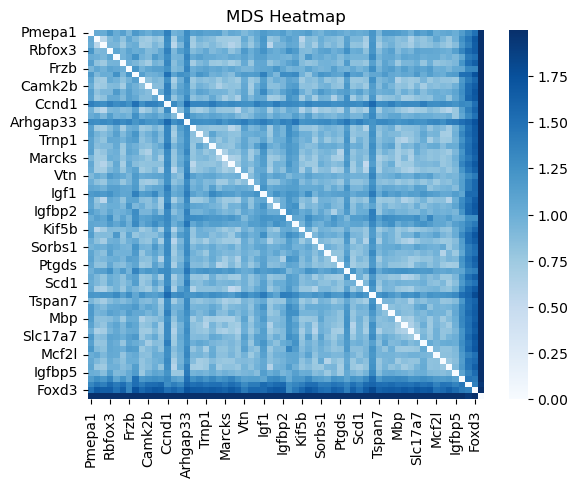

In [169]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(arr, cmap='Blues', fmt=".1f")
plt.title('MDS Heatmap')
plt.show()

In [152]:
result = cluster(arr, n_clusters=6, mds_components=50, method='kmeans')
result

gene_id  labels
0   Pmepa1       2
1     Pcp4       0
2      Apc       0
3   Rbfox3       5
4    Gng13       2
..     ...     ...
57  Igfbp5       2
58     Ptn       2
59  Unc13c       3
60   Foxd3       1
61  Prokr2       4

[62 rows x 2 columns]

C:\Users\pssun\AppData\Local\Temp\ipykernel_31008\2403062509.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(arr, method='complete')


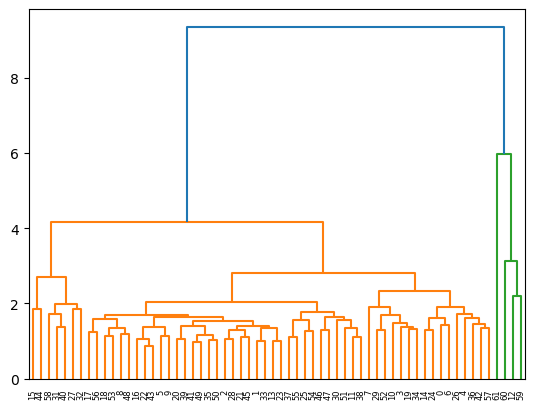

In [153]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

Z = linkage(arr, method='complete')

# 绘制谱系图
dendrogram(Z)
plt.show()

In [141]:
labels = fcluster(Z, 2, criterion='distance')
labels

array([ 6,  3,  3,  5,  6,  3,  6,  5,  3,  3,  5,  4,  7,  3,  6,  1,  3,
        3,  3,  5,  3,  3,  3,  3,  6,  4,  6,  2,  3,  5,  4,  2,  2,  3,
        5,  3,  6,  4,  4,  3,  2,  3,  6,  3,  1,  3,  4,  4,  3,  3,  3,
        4,  5,  3,  4,  4,  3,  6,  2,  8,  9, 10], dtype=int32)

In [132]:
arr['labels'] = labels

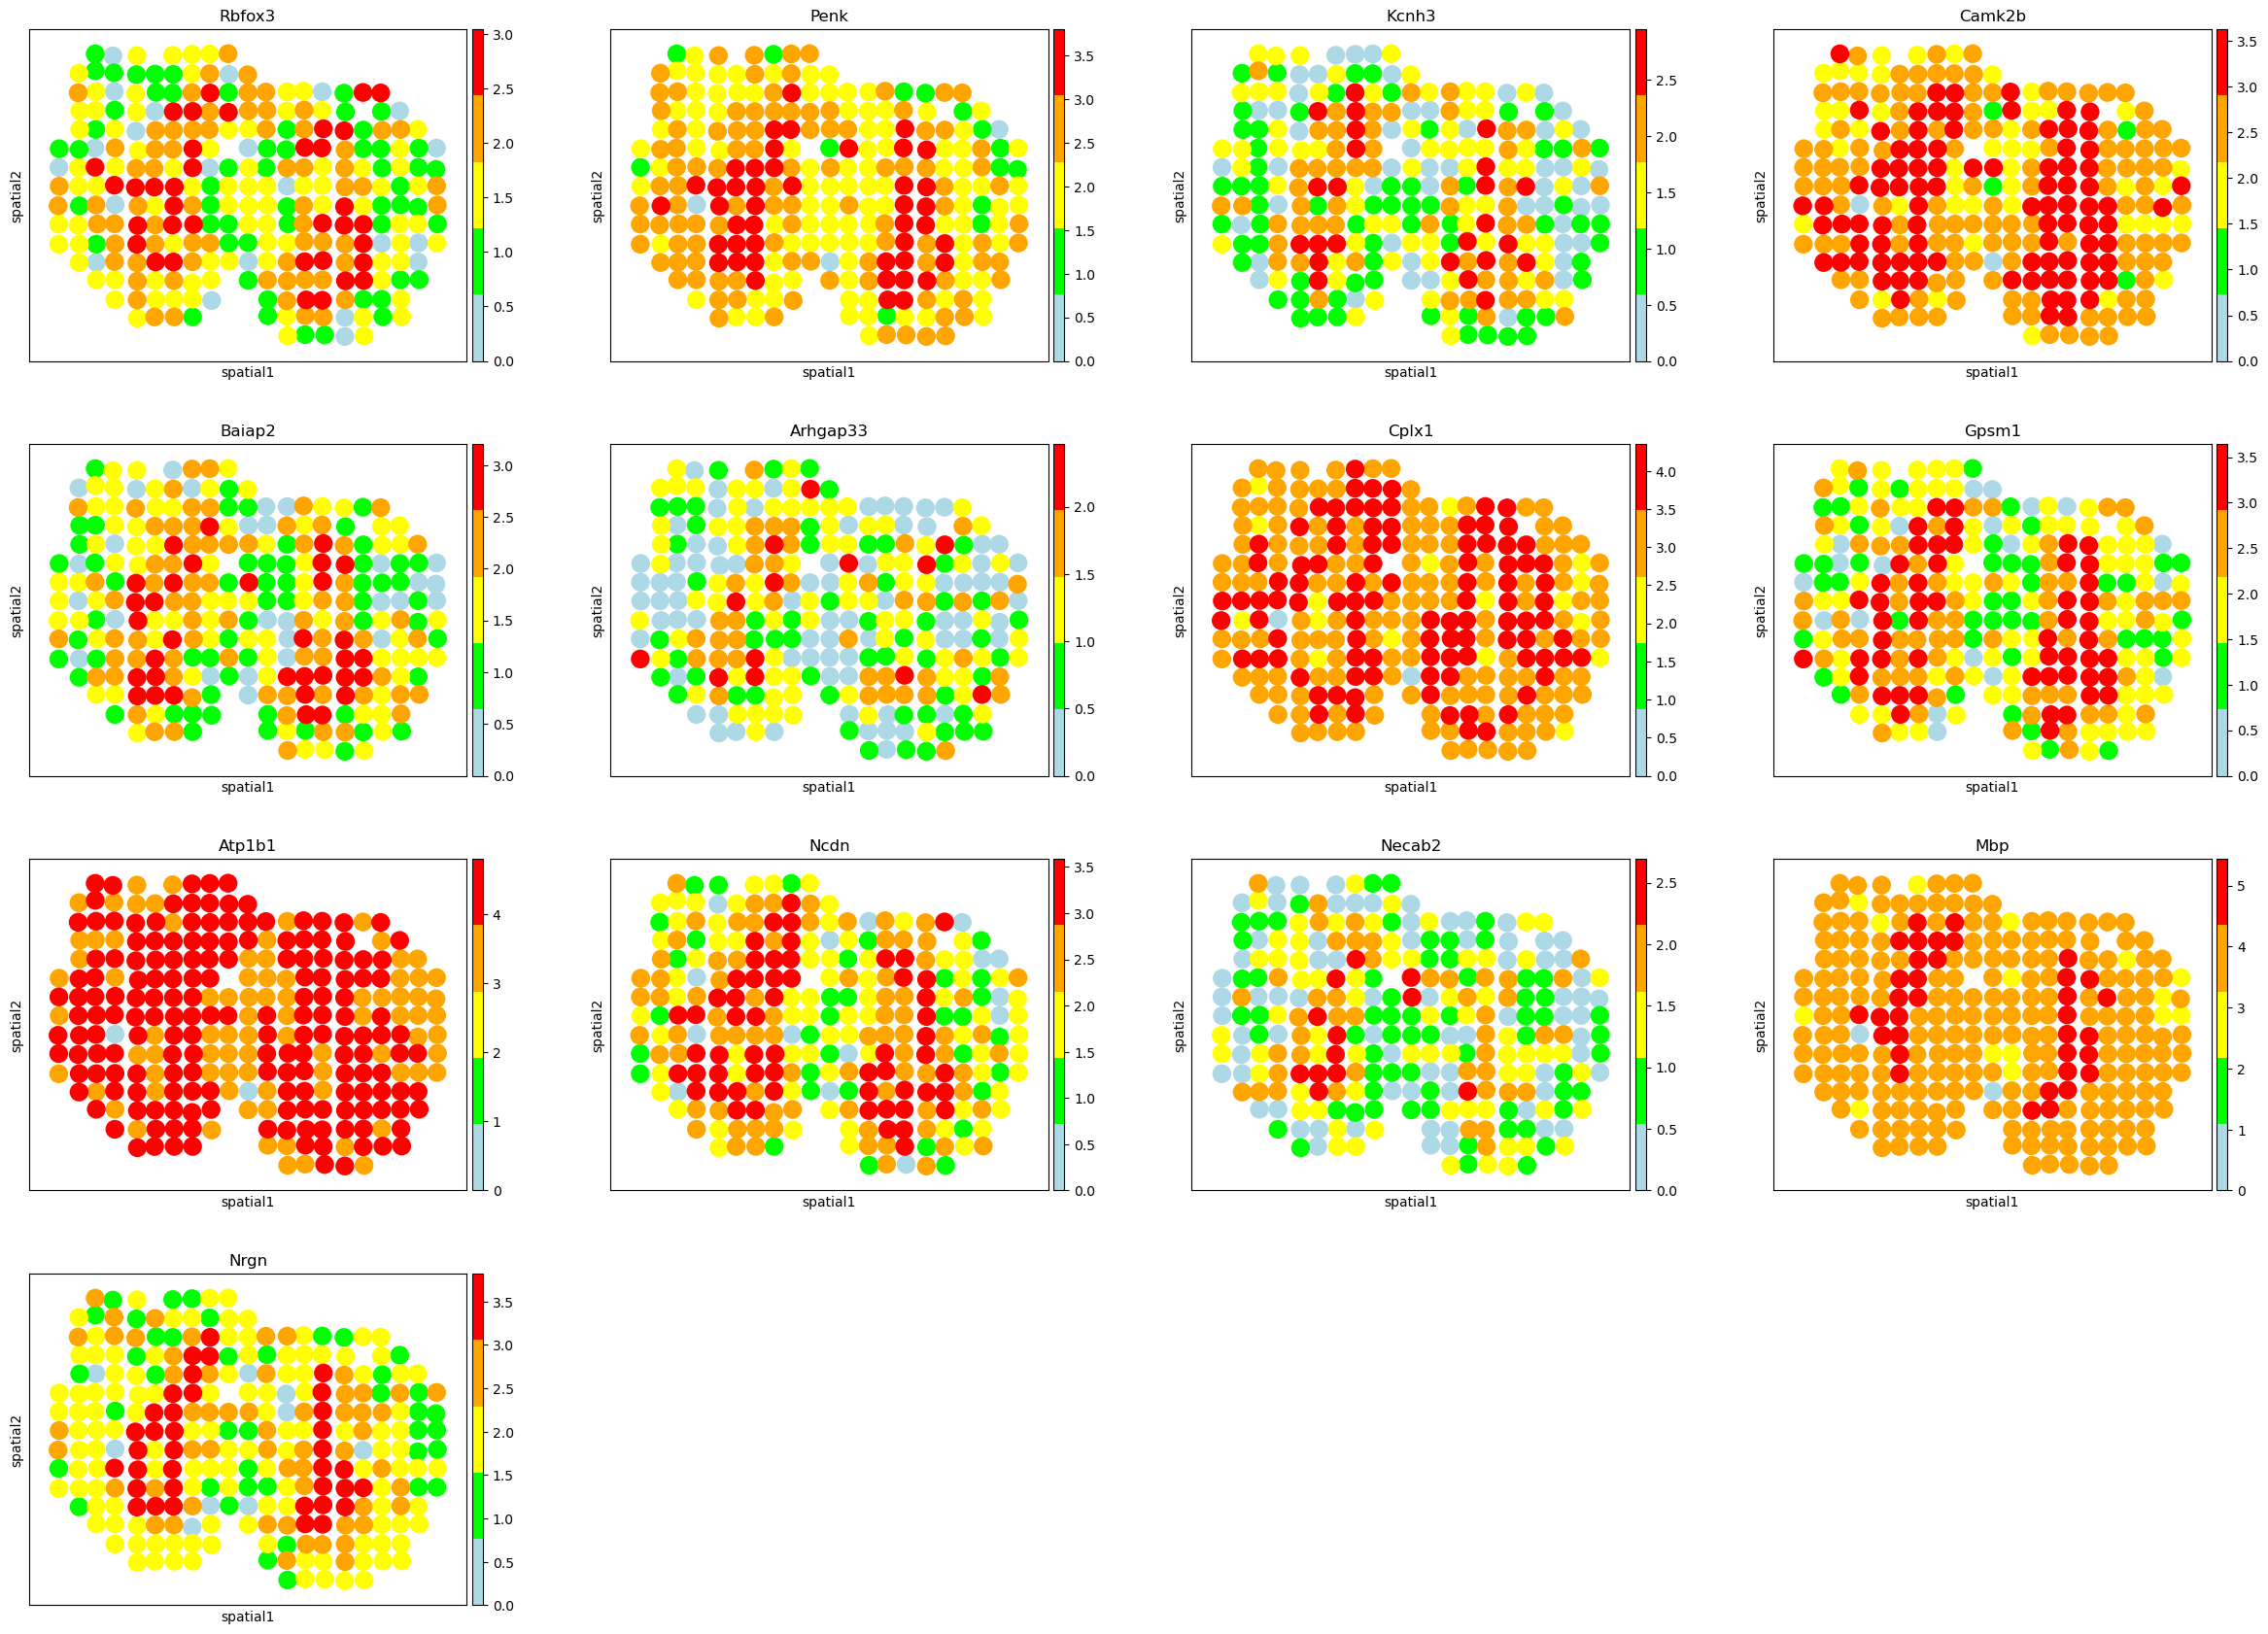

In [161]:
import scanpy as sc
import matplotlib.colors as colors

new_colors = ['lightblue', '#00FF00', '#FFFF00', '#FFA500', '#FF0000']
new_cmap = colors.ListedColormap(new_colors)
sc.pl.spatial(adata,
              size=2,
              spot_size=.5,
              cmap=new_cmap,
              # color=list(arr[arr['labels'] == ].index)
              color=result[result['labels']==5]['gene_id']
              )

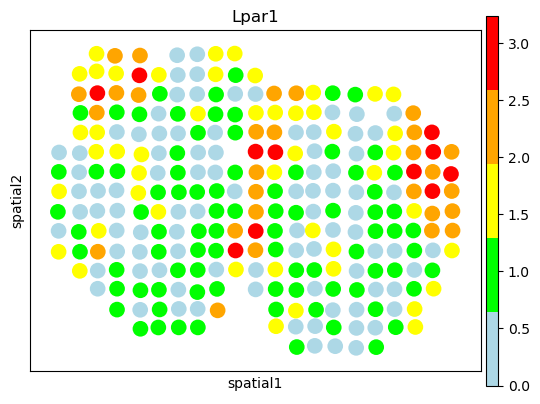

In [77]:
new_colors = ['lightblue', '#00FF00', '#FFFF00', '#FFA500', '#FF0000']
sc.pl.spatial(adata,
              size=.8,
              spot_size=1,
              cmap=new_cmap,
              color=['Lpar1'])

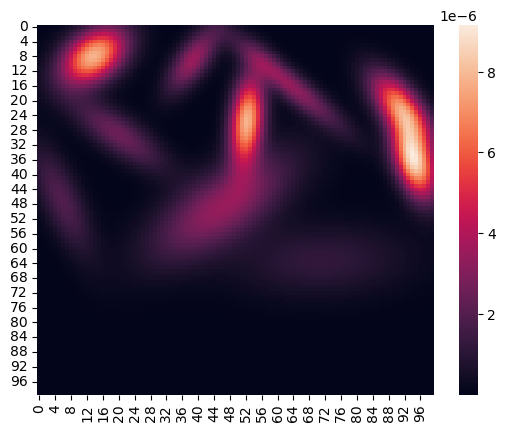

In [61]:
def fit_gmm(adata: anndata,
            gene_name: str,
            n_comp: int = 2,
            max_iter: int = 200,
            reg_covar=1e-3):
    """
    Representation of a Gaussian mixture model probability distribution.
    Estimate the parameters of a Gaussian mixture distribution.

    Estimate model parameters with the EM algorithm.

    :param reg_covar:
    :type reg_covar:
    :param adata: Anndata of spatial data
    :type adata: Anndata
    :param gene_name: The gene name to fit
    :type gene_name: str
    :param n_comp: The number of mixture components.
    :type n_comp: int
    :param max_iter: The number of EM iterations to perform.
    :type max_iter: int
    :return: The number of components and the fitted mixture.
    :rtype: GaussianMixture
    """
    dense_array = get_exp_array(adata, gene_name)
    # dense_array[dense_array < 2] = 0
    result = np.array(array_to_list(dense_array))
    # Number of unique center must be larger than the number of components.
    if len(set(map(tuple, result))) >= n_comp:
        gmm = mixture.GaussianMixture(n_components=n_comp, max_iter=max_iter, reg_covar=reg_covar, n_init=5)
        gmm.fit(result)
        return gmm
    else:
        return None

gmm = fit_gmm(adata, 'Lpar1', n_comp=10, max_iter=10000, reg_covar=1e-3)
view_gmm(gmm, scope=(0, max(adata.obs['y'].max(), adata.obs['x'].max())), bin_count=100)

In [149]:
gmm.converged_model_

AttributeError: 'GaussianMixture' object has no attribute 'converged_model_'

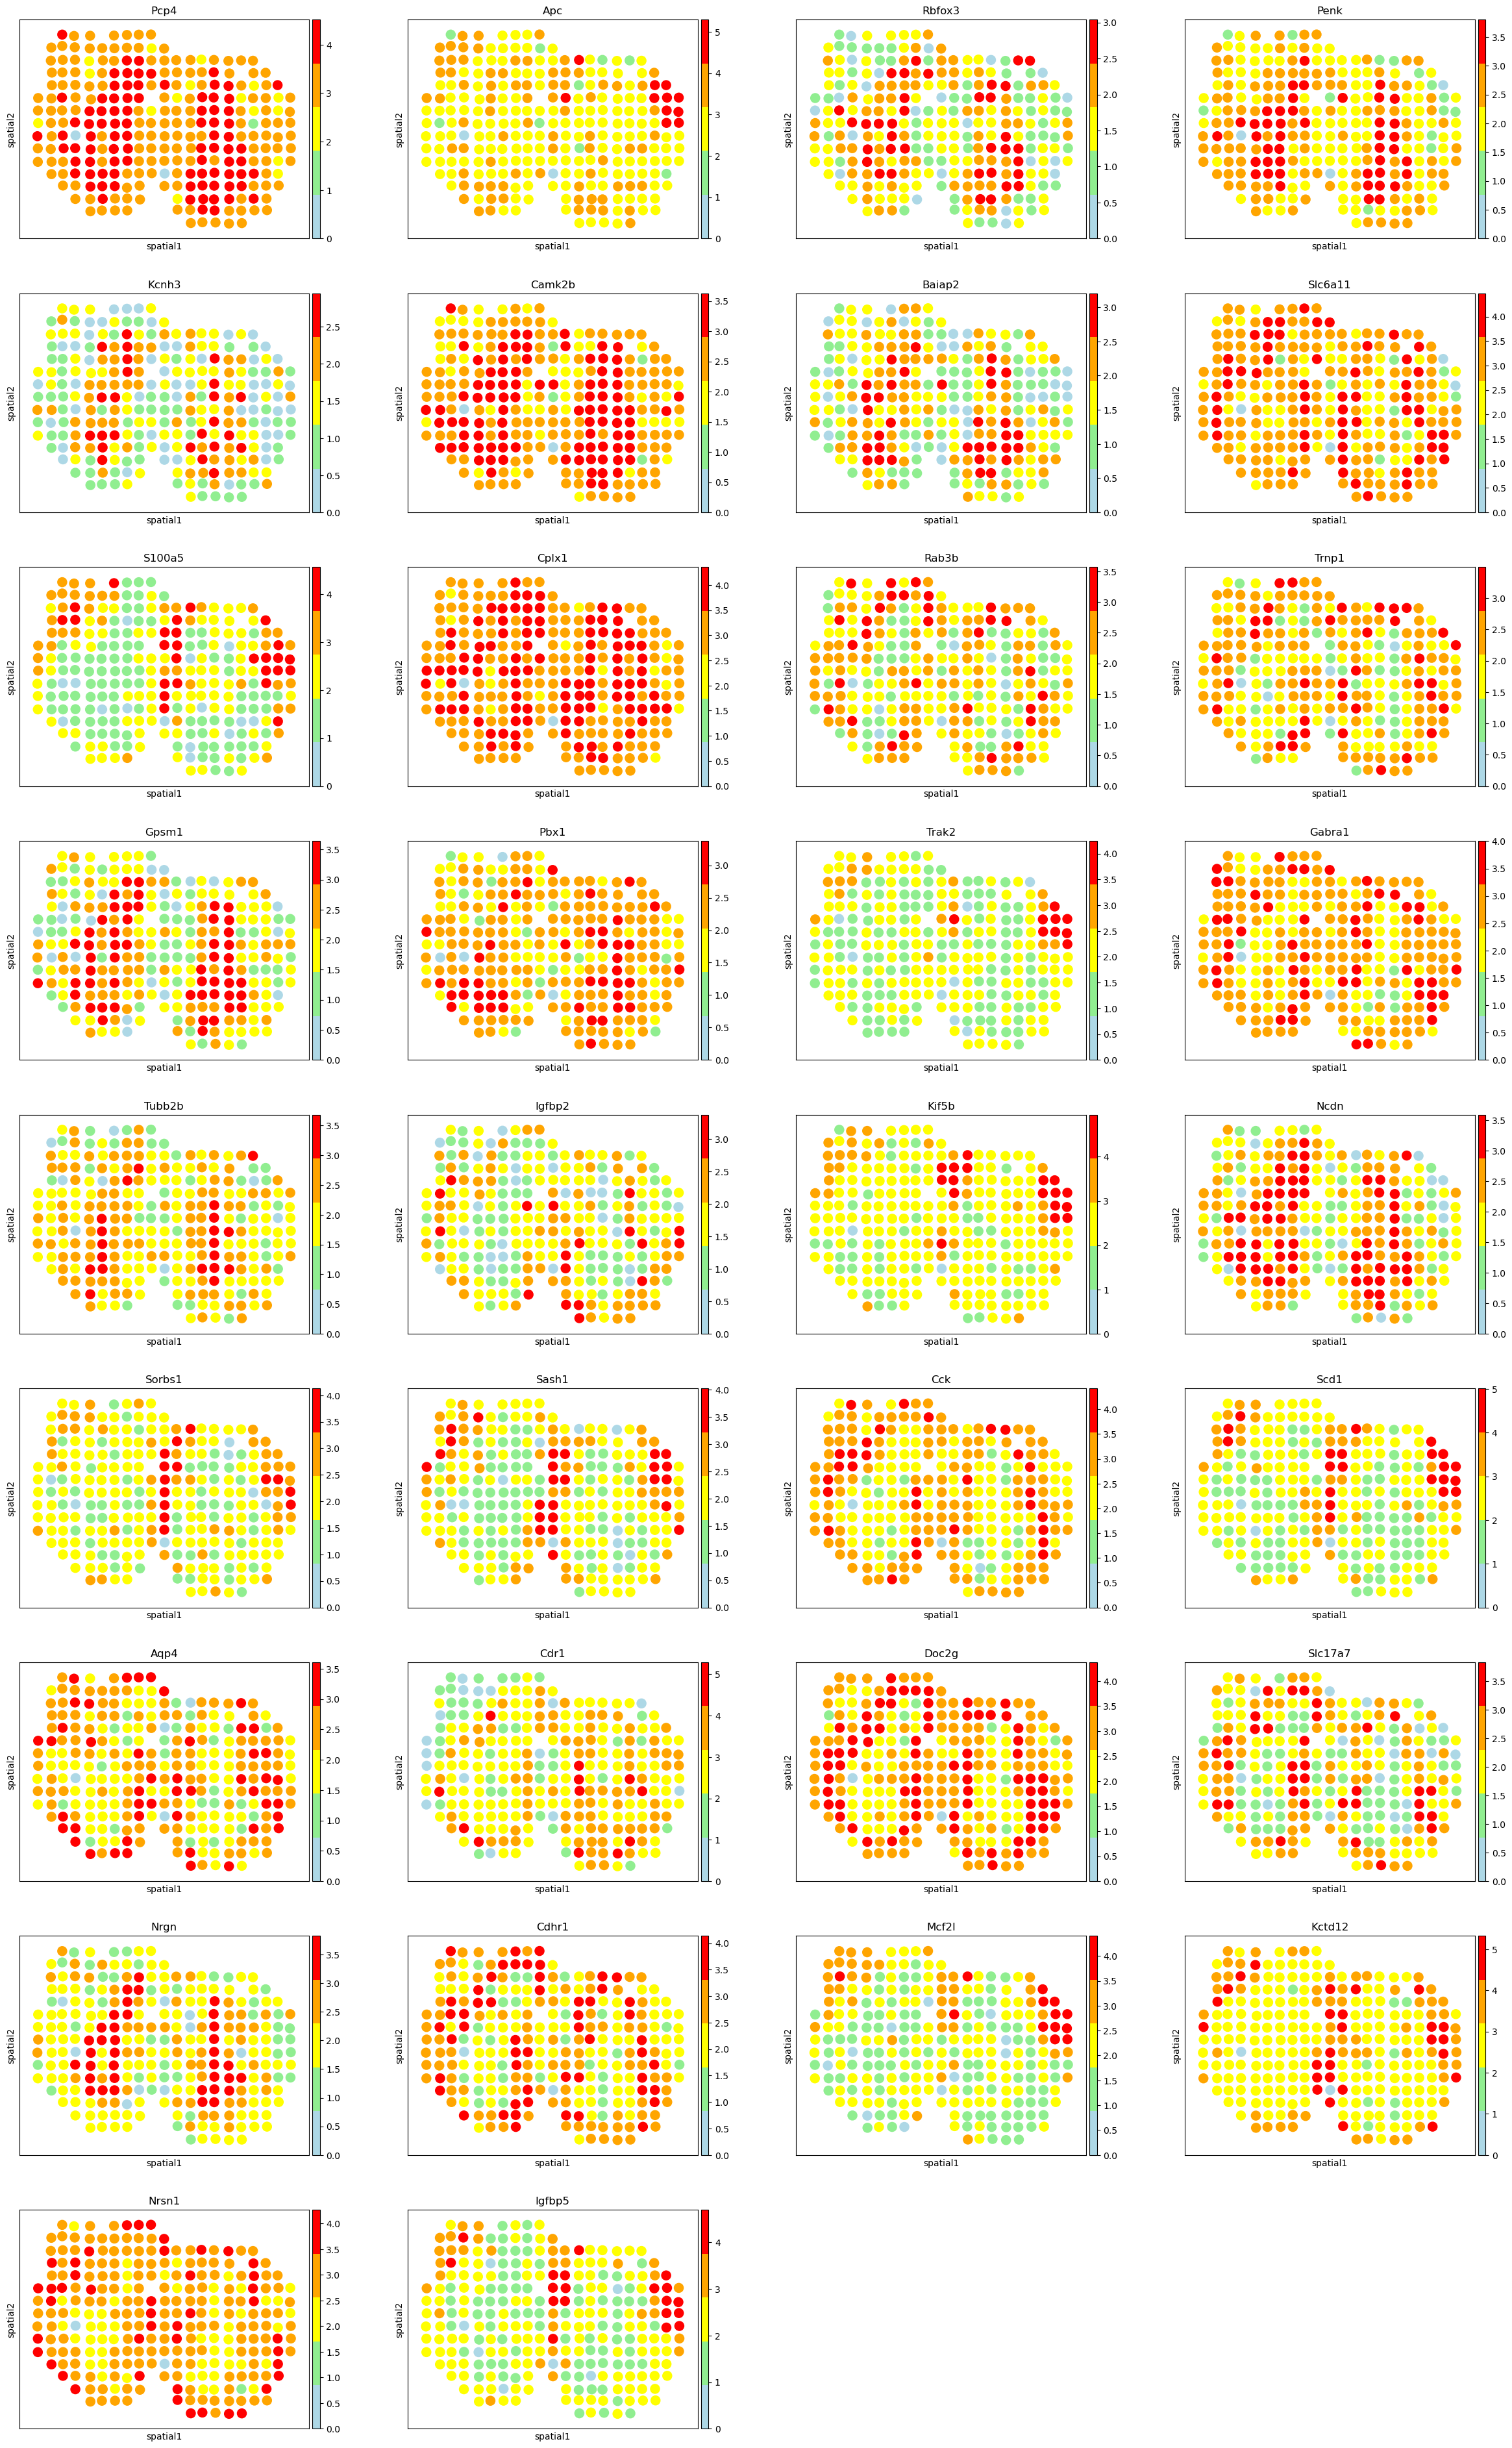

In [66]:
import scanpy as sc
import matplotlib.colors as colors

new_colors = ['lightblue', 'lightgreen', 'yellow', '#FFA500', '#FF0000']
new_cmap = colors.ListedColormap(new_colors)

sc.pl.spatial(new_adata,
              size=.8,
              spot_size=1,
              cmap=new_cmap,
              color=result[result['labels']==1]['gene_id'])

In [16]:
from Algorithm.graph import *
graph = build_graph(gmm_dict, distance_threshold=1.1)

100%|██████████| 62/62 [00:13<00:00,  4.63it/s]


In [5]:
import numpy as np
import cv2

#p、q是两个矩阵，第一列表示权值，后面三列表示直方图或数量

pp=cv2.fromarray(p)
qq=cv2.fromarray(q)
emd=cv2.CalcEMD2(pp,qq,cv2.CV_DIST_L2)

NameError: name 'cv' is not defined

In [7]:
from scipy.stats import wasserstein_distance

import cv2.




AttributeError: module 'cv2' has no attribute 'cv'

In [61]:
import ot

X = np.array([[1, 5, 1, 0],
              [5, 10, 5, 0],
              [1, 5, 1, 0],
              [0, 0, 0, 0]], np.float32)

Y = np.array([[0, 0, 0, 0],
              [0, 1, 5, 1],
              [0, 5, 10, 5],
              [0, 1, 5, 1]], np.float32)

coords = np.array([X.flatten(), Y.flatten()]).T
coordsSqr = np.sum(coords ** 2, 1)
M = coordsSqr[:, None] + coordsSqr[None, :] - 2 * coords.dot(coords.T)
# M[M < 0] = 0
M = np.sqrt(M)

ot.sinkhorn2(X.flatten(), Y.flatten(), M, 1.0)

0.075425655

In [100]:
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

a = np.array([[1, 5, 1, 0],
              [5, 10, 5, 0],
              [1, 5, 1, 0],
              [0, 0, 0, 0]], np.int32)

b = np.array([[0, 5, 5, 0],
              [0, 10, 5, 0],
              [0, 5, 10, 0],
              [0, 1, 0, 1]], np.int32)


d = cdist(a, b)
assignment = linear_sum_assignment(d)
print(d[assignment].sum() / 16)

1.224544020383011


In [65]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot
xs = np.array([[6, 5, 1, 0],
              [5, 10, 5, 0],
              [1, 5, 1, 0],
              [0, 2, 8, 0]], np.int32)

xt = np.array([[0, 5, 5, 0],
              [0, 10, 5, 0],
              [0, 5, 10, 0],
              [0, 3, 10, 0]], np.int32)
n = 16
a, b = np.ones((n,)) / n, np.ones((n,)) / n
M = ot.dist(xs, xt)
print(M)

[[ 52  77 117 121]
 [ 50  25  75  99]
 [ 17  42  82  86]
 [ 18  73  13   5]]


Text(0.5, 1.0, 'Cost matrix M')

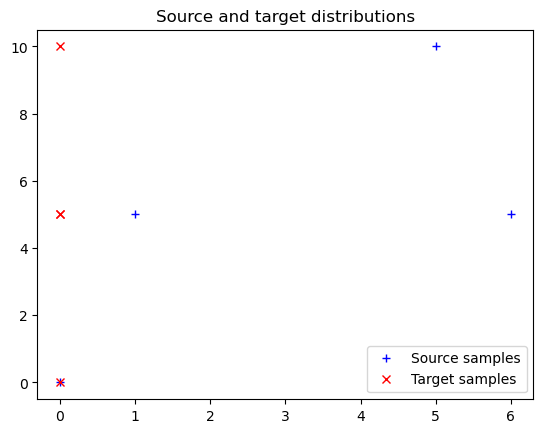

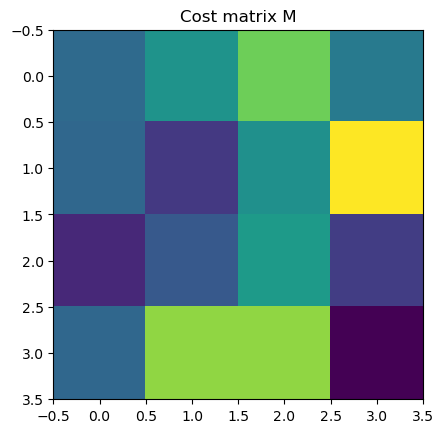

In [64]:
pl.figure(1)
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('Source and target distributions')

pl.figure(2)
pl.imshow(M, interpolation='nearest')
pl.title('Cost matrix M')

In [74]:
n = 5000  # nb samples

mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)

a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)

Text(0.5, 1.0, 'Cost matrix M')

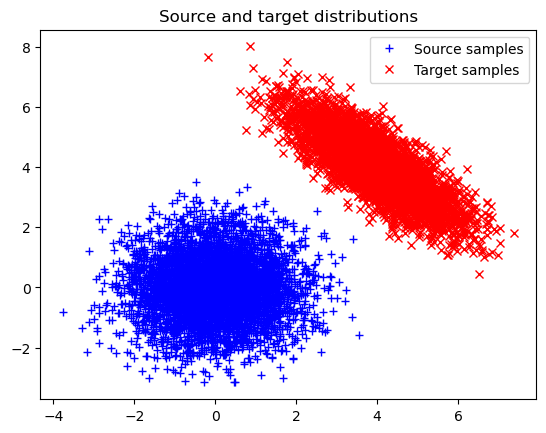

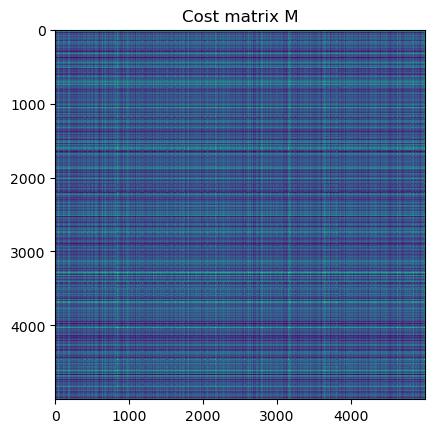

In [83]:
pl.figure(1)
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('Source and target distributions')

pl.figure(2)
pl.imshow(M, interpolation='nearest')
pl.title('Cost matrix M')